In [281]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import riskfolio as rp

In [6]:
yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

In [5]:
# Date range
start = '2016-01-01'
end = '2019-12-30'

In [7]:
assets = ['SPY', 'GLD', 'TLT']
assets.sort()

In [46]:
# Downloading data
# divide by hundred to obtain price
data = (yf.download(assets, start = start, end = end)/100)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%***********************]  3 of 3 completed


In [49]:
# Calculating returns
# pct change between the current and a prior element
Y = data[assets].pct_change().dropna()
Y

,GLD,SPY,TLT
Date,,,
2016-01-04,1.4094%,-1.3979%,0.7215%
2016-01-05,0.2819%,0.1691%,-0.4034%
2016-01-06,1.4441%,-1.2614%,1.3475%
2016-01-07,1.4140%,-2.3992%,0.1795%
2016-01-08,-0.4428%,-1.0977%,0.4479%
...,...,...,...
2019-12-20,0.1004%,0.4384%,0.1319%
2019-12-23,0.3082%,0.1528%,-0.1464%
2019-12-24,0.9432%,0.0031%,0.2858%


### Using an equal risk contribution portfolio

In [48]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # use estimates of expected return vector and covariance matrix that depends on historical data
rm = 'MV' # Risk measure used, Standard Deviation
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate (the rate of return of an investment with no risk of loss)
b = None # vector of risk constraints per asset 
w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,GLD,SPY,TLT
weights,27.8529%,37.9312%,34.2159%


In [76]:
# Model
w_rp.loc["GLD", "weights"]

0.2785288572030592

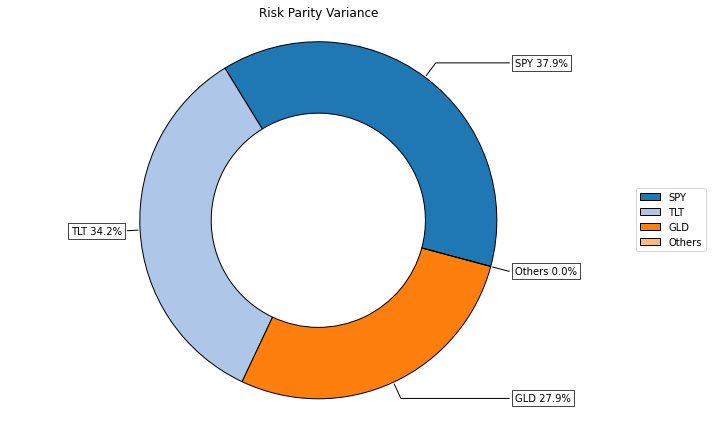

In [50]:
ax = rp.plot_pie(w=w_rp,
                 title='Risk Parity Variance',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

### Backtesting

Metholodogy
- Sliding window approach
- Run Risk parity model on ith year
- Obtain weights from ith year and use on (i+1)th year
- Simultaneously calculate both portfolio performance using Volatility, Returns, Sharpe Ratio for baseline(1/3 weight for each asset) and Risk Parity Weights on (i+1)th year
- Compare metrics in pandas dataframe

Assume
- risk free rate of 2.85%
- assume no transaction cost/commission rate

In [277]:
# Run test on y1, test performance on y2
# Download
def download_data(cur_year, returns = 0):
    # start and end of year
    first_day_of_year = datetime.date.min.replace(year = cur_year)
    last_day_of_year = datetime.date.max.replace(year = cur_year)

    # download for assets
    assets = ['SPY', 'GLD', 'TLT']
    assets.sort()
    data = yf.download(assets, start = first_day_of_year, end = last_day_of_year)
    data = data.loc[:,('Adj Close', slice(None))]
    data.columns = assets

    if returns:
        return data, data[assets].pct_change().dropna()
    return data

# Model
def model_rpp(returns_daily):
    # Building the portfolio object
    port = rp.Portfolio(returns = returns_daily)

    # Calculating optimal portfolio

    # Select method and estimate input parameters:

    method_mu='hist' # Method to estimate expected returns based on historical data.
    method_cov='hist' # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    # Estimate optimal portfolio:

    model='Classic' # use estimates of expected return vector and covariance matrix that depends on historical data
    rm = 'MV' # Risk measure used, Standard Deviation
    hist = True # Use historical scenarios for risk measures that depend on scenarios
    rf = 0 # Risk free rate (the rate of return of an investment with no risk of loss)
    b = None # vector of risk constraints per asset 
    w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)
    return w_rp

# obtain weights for specific asset
def obtain_weight(rp_df, asset):
    #assets = ['SPY', 'GLD', 'TLT']
    return rp_df.loc[asset, "weights"]

# Test on y2  
# start price in y2
def obtain_start_price(asset, df):
    return df.iloc[0, :][asset] 

# final price end of y2 for specific asset
def obtain_end_price(asset, df):
    return df.iloc[-1, :][asset]

def calculate_volatility(returns, alloc_pct):
    covariance = np.cov(returns.T)
    if type(alloc_pct) == type(pd.DataFrame()):
        weight_vector = alloc_pct.to_numpy().T
    else:
        weight_vector = alloc_pct
        
    portfolio_volatility = np.sqrt(np.dot(np.dot(weight_vector, covariance), weight_vector.T))
    return portfolio_volatility[0][0]

def calculate_sharpe_ratio(returns):
    # risk free rate from US treasury bond is 2.85%, 252 trading days annualized
    num_trading_days = 252
    sqrt_day = np.sqrt(num_trading_days)
    return (returns.mean()*num_trading_days - 0.0285)/(returns.std()*np.sqrt(num_trading_days))

In [280]:
portfolio_volatility = []
baseline_portfolio_volatility = []
annual_returns = []
baseline_annual_returns = []
sharpe_list = []
baseline_sharpe_list = []

base = 0
init = 0

start_year = 2010
end_year = 2019
downloaded_data = [False for i in range(start_year, end_year)]

# Year Test
for cur_year in range(start_year, end_year):
    if cur_year < end_year-1:
        assets = ['SPY', 'GLD', 'TLT']
        assets.sort()

        # to set index for downloaded_data
        if init == 0:
            base_year = cur_year
            init = 1

        # Store to avoid repeated downloads
        # Download data, Y1
        idx_i = cur_year-base_year
        # not present, download
        if not downloaded_data[idx_i]:
            downloaded_data_y1, downloaded_data_y1_returns = download_data(cur_year, True)
            downloaded_data[idx_i] = [downloaded_data_y1, downloaded_data_y1_returns]
        # if present, retrieve
        else:
            downloaded_data_y1, downloaded_data_y1_returns = downloaded_data[idx_i][0], downloaded_data[idx_i][1]

        # Download data, Y2 
    #         print(len(downloaded_data))
    #         print(cur_year, idx_i+1)
        if not downloaded_data[idx_i+1]:
            downloaded_data_y2, downloaded_data_y2_returns = download_data(cur_year + 1, True)
            downloaded_data[idx_i+1] = [downloaded_data_y2, downloaded_data_y2_returns]
        else:
            downloaded_data_y2, downloaded_data_y2_returns = downloaded_data[idx_i+1][0], downloaded_data[idx_i+1][1]

        # deep copy for separate baseline values
        baseline_downloaded_data_y2 = downloaded_data_y2.copy(deep = True)

        # starting variables
        alloc_pct = model_rpp(downloaded_data_y1_returns)
        returns_df = {}
        starting_amt = 100000
        new_portfolio = 0
        new_baseline_portfolio = 0

        for asset in assets:
            weight =  obtain_weight(alloc_pct, asset)
            # RPP
            budget = weight * starting_amt
            # Baseline
            baseline_budget = (1/3) * starting_amt

            # start price in y2
            start_price = obtain_start_price(asset, downloaded_data_y2)
            # RPP
            position_size = budget/start_price
            downloaded_data_y2[asset] = downloaded_data_y2[asset] * position_size

            # Baseline
            baseline_position_size  = baseline_budget/start_price
            baseline_downloaded_data_y2[asset] = baseline_downloaded_data_y2[asset] * baseline_position_size


        downloaded_data_y2["Total"] = downloaded_data_y2[list(downloaded_data_y2.columns)].sum(axis = 1)
        baseline_downloaded_data_y2["Total"] = baseline_downloaded_data_y2[list(baseline_downloaded_data_y2.columns)].sum(axis = 1)
        
        new_portfolio = obtain_end_price("Total", downloaded_data_y2)
        new_baseline_portfolio = obtain_end_price("Total", baseline_downloaded_data_y2)

        # calculate sharpe ratio
        sharpe = calculate_sharpe_ratio(downloaded_data_y2["Total"].pct_change(1).dropna())
        baseline_sharpe = calculate_sharpe_ratio(baseline_downloaded_data_y2["Total"].pct_change(1).dropna())
        sharpe_list.append(sharpe)
        baseline_sharpe_list.append(baseline_sharpe)

        # volatility
        volatility = calculate_volatility(downloaded_data_y2_returns, alloc_pct)
        baseline_volatility = calculate_volatility(downloaded_data_y2_returns, np.array([[1/3]*3]))

        # baseline volatility
        portfolio_volatility.append(volatility)
        baseline_portfolio_volatility.append(baseline_volatility)

        # overall returns 
        overall_portfolio_returns = ((new_portfolio-starting_amt)/starting_amt) * 100
        baseline_overall_portfolio_returns = ((new_baseline_portfolio-starting_amt)/starting_amt) * 100

        # baseline overall returns
        annual_returns.append(overall_portfolio_returns)
        baseline_annual_returns.append(baseline_overall_portfolio_returns)

pd.DataFrame({"portfolio_volatility" : portfolio_volatility, "baseline_portfolio_volatility" :baseline_portfolio_volatility,
             "annual_returns" : annual_returns, "baseline_annual_returns":annual_returns,
              "sharpe_ratio":sharpe_list, "baseline_sharpe_ratio":baseline_sharpe_list}, index = [i for i in range(start_year+1, end_year)])

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  3 of 3 completed


,portfolio_volatility,baseline_portfolio_volatility,annual_returns,baseline_annual_returns,sharpe_ratio,baseline_sharpe_ratio
2011,0.005133,0.005693,16.845092,16.845092,1.555847,1.265016
2012,0.003929,0.004442,7.580500,7.580500,0.771303,0.609247
2013,0.005250,0.006237,2.487065,2.487065,-0.008562,-0.634795
2014,0.003445,0.004006,16.411130,16.411130,2.326263,1.627696
2015,0.004997,0.005095,-2.180331,-2.180331,-0.600755,-0.764060
2016,0.004575,0.004827,7.226825,7.226825,0.589769,0.541201
2017,0.003007,0.003444,14.786016,14.786016,2.350179,1.899591
2018,0.005449,0.004213,-4.084463,-4.084463,-0.761478,-0.911333


# Test Calculations

In [196]:
test_data, test_data_returns = download_data(2020, 1)

[*********************100%***********************]  3 of 3 completed


In [235]:
calculate_volatility(downloaded_data_y2_returns, alloc_pct)

0.00544912453951916

In [253]:
pd.DataFrame({"col1" : [1,2,3,4]}).pct_change().dropna()

,col1
1,1.000000
2,0.500000
3,0.333333


In [237]:
downloaded_data_y2_returns

,GLD,SPY,TLT
Date,,,
2018-01-03,-0.002637,0.006325,0.004781
2018-01-04,0.005127,0.004215,-0.000158
2018-01-05,-0.001036,0.006664,-0.002856
2018-01-08,-0.000160,0.001829,-0.000636
2018-01-09,-0.004628,0.002263,-0.013373
...,...,...,...
2018-12-21,-0.004361,-0.020490,-0.000166
2018-12-24,0.010950,-0.026423,0.004970
2018-12-26,-0.002999,0.050525,-0.010715


##### Numpy  Sum total

In [197]:
value_alloc = model_rpp(test_data_returns)*starting_amt

In [198]:
value_alloc

,weights
GLD,30179.187973
SPY,27518.537734
TLT,42302.274293


In [199]:
# start prices
obtain_start_price(assets, test_data).to_numpy()

array([142.8999939 , 310.83752441, 130.91235352])

In [200]:
# position sizes
position_sizes = np.divide(value_alloc.to_numpy().T, obtain_start_price(assets, test_data).to_numpy().T)
position_sizes

array([[211.19096754,  88.530295  , 323.1343197 ]])

In [201]:
obtain_end_price(assets, test_data).to_numpy()

array([177.69999695, 365.95974731, 154.45036316])

In [202]:
np.dot(position_sizes, obtain_end_price(assets, test_data).to_numpy())

array([119835.37170272])

In [203]:
223.75301918*142.63000488 + 171.96897392*310.08432007 + 280.12295729*132.2071991

122273.04815559671

In [204]:
np.dot(position_sizes, obtain_start_price(assets, test_data).to_numpy())

array([100000.])

In [205]:
(122273.04815559671 - 100000)/100000

0.2227304815559671

# Metrics for performance
# Experimenting

In [38]:
import yfinance as yf
# get the list of ticker symbols
snp_ticker_symbols = ["GLD", "SPY"]
# download some data from yahoo
data = yf.download(
        tickers = snp_ticker_symbols,
        period = '3mo',
        interval = '1d'
    )
prices = data['Adj Close']

import numpy as np
returns = prices.pct_change()
# first we choose the parameters of the Dirichlet distribution
alphas = .05*np.ones(returns.shape[1])
# sample 100 random portfolios
portfolio = np.random.dirichlet(alphas, size=1)

[*********************100%***********************]  2 of 2 completed


In [49]:
returns.fillna(0).T

Date,2022-01-18,2022-01-19,2022-01-20,2022-01-21,2022-01-24,2022-01-25,2022-01-26,2022-01-27,2022-01-28,2022-01-31,...,2022-04-04,2022-04-05,2022-04-06,2022-04-07,2022-04-08,2022-04-11,2022-04-12,2022-04-13,2022-04-14,2022-04-18
GLD,0.0,0.015881,-0.002499,-0.003262,0.005494,0.003197,-0.016166,-0.012898,-0.002983,0.005925,...,0.004847,-0.006265,0.002343,0.003785,0.006266,0.004959,0.007677,0.004789,-0.003304,0.009225
SPY,0.0,-0.010384,-0.011068,-0.019631,0.004247,-0.012209,-0.002509,-0.004938,0.024835,0.018011,...,0.008567,-0.012631,-0.009999,0.005039,-0.002674,-0.017092,-0.003705,0.011454,-0.012452,0.002284


In [47]:
covariance = np.cov(returns.fillna(0).T)

In [48]:
covariance

array([[ 9.98329686e-05, -5.24688368e-05],
       [-5.24688368e-05,  1.79242690e-04]])

In [57]:
portfolio

array([[9.99999974e-01, 2.63967876e-08]])

In [ ]:
portfolio_volatility = np.sqrt(np.dot(np.dot(portfolio, covariance), portfolio.T))

## Actual

### Volatility

In [51]:
downloaded_data_y1, downloaded_data_y1_returns = download_data(2016, True)

[*********************100%***********************]  3 of 3 completed


In [54]:
covariance = np.cov(downloaded_data_y1_returns.T)

In [55]:
covariance

array([[ 1.03882540e-04, -2.94840813e-05,  4.03527566e-05],
       [-2.94840813e-05,  6.76972391e-05, -2.49866523e-05],
       [ 4.03527566e-05, -2.49866523e-05,  6.63123314e-05]])

In [61]:
weight_vector = model_rpp(downloaded_data_y1_returns).to_numpy().T

In [64]:
portfolio_volatility = np.sqrt(np.dot(np.dot(weight_vector, covariance), weight_vector.T))
portfolio_volatility[0][0]

0.004349707745617772

#### Sharpe Ratio

In [104]:
def calculate_sharpe_ratio(returns):
    return (252*0.5)*(returns.mean()/returns.std())
calculate_sharpe_ratio(downloaded_data_y1_returns)

GLD    11.544749
SPY    17.626270
TLT     9.966710
dtype: float64

In [ ]:
 df[list(df.columns)].sum(axis=1)

In [121]:
downloaded_data_y1["Total"] = downloaded_data_y1[list(downloaded_data_y1.columns)].sum(axis = 1)
downloaded_data_y1

,GLD,SPY,TLT,Total
Date,,,,
2018-12-31,271.275383,407.385456,321.339161,1000.000000
2019-01-02,271.454372,407.809299,323.031674,1002.295345
2019-01-03,273.915424,398.077851,326.707605,998.700880
2019-01-04,271.700479,411.411709,322.925887,1006.038075
2019-01-07,272.640151,414.655595,321.973821,1009.269568
...,...,...,...,...
2019-12-23,313.113311,533.524022,369.332642,1215.969975
2019-12-24,316.066593,533.540607,370.388336,1219.995536
2019-12-26,318.550023,536.380831,371.281566,1226.212420


In [135]:
obtain_start_price("GLD", downloaded_data_y1)

271.3048370007222